# GEO Routes with Folium

Load a route JSON from GCS as a Python dict, extract coordinates, and plot on an interactive folium map (no DataFrame needed).

**Requirements**
- `folium` for the map
- `gcsfs` (via `fsspec`) to read from GCS with your existing GCP auth
- Notebook trusted to display folium output

In [1]:
import json
from typing import List, Tuple

import folium
import fsspec  # to read from GCS
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Install folium/gcsfs if missing (uncomment and run once)
# !pip install folium gcsfs


### Helpers
- `load_route_json_from_gcs`: read the JSON object from your bucket into a dict
- `extract_coords`: pull (lat, lon) pairs from a GeoJSON/ORS-like structure (FeatureCollection with LineString/MultiLineString)
- `plot_route_coords`: plot the coordinate list with a polyline and start/end markers

In [3]:
def load_route_json_from_gcs(bucket: str, path: str, token: str = "google_default") -> dict:
    """Load a JSON file from GCS as a Python dict using fsspec."""
    uri = f"gs://{bucket}/{path}" # construct GCS URI
    fs = fsspec.filesystem("gcs", token=token) # connect to GCS
    with fs.open(uri, "rb") as f:
        return json.load(f)


def extract_coords(route_json: dict) -> Tuple[List[Tuple[float, float]], List[float]]:
    """Extract (lat, lon) pairs and elevation data from a GeoJSON/ORS-like route dict.

    Returns:
        Tuple of (coords, elevations) where coords is list of (lat, lon) and elevations is list of heights
    """
    # Typical ORS/GeoJSON: FeatureCollection -> first feature -> geometry
    if route_json.get("type") == "FeatureCollection":
        features = route_json.get("features", [])
        if not features:
            raise ValueError("No features found in route JSON")
        geom = features[0].get("geometry", {})
    else:
        # Fallback: assume the dict itself has geometry
        geom = route_json.get("geometry", {})

    gtype = geom.get("type")
    coords = geom.get("coordinates", [])

    coord_list = []
    elev_list = []

    if gtype == "LineString":
        # coords is list of [lon, lat, elev] triplets
        for lon, lat, elev in coords:
            coord_list.append((lat, lon))
            elev_list.append(elev)
    elif gtype == "MultiLineString":
        for line in coords:
            for lon, lat, elev in line:
                coord_list.append((lat, lon))
                elev_list.append(elev)
    else:
        raise ValueError(f"Unsupported geometry type: {gtype}")

    return coord_list, elev_list


def plot_route_coords(coords: List[Tuple[float, float]]) -> folium.Map:
    """Plot a route from a list of (lat, lon) tuples on an interactive map."""
    if len(coords) < 2:
        raise ValueError("Need at least two points to draw a route")

    # Center map on mean lat/lon
    lats, lons = zip(*coords)
    center_lat = sum(lats) / len(lats)
    center_lon = sum(lons) / len(lons)

    m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

    folium.PolyLine(coords, color="blue", weight=5, opacity=0.8, tooltip="Route").add_to(m)

    start_lat, start_lon = coords[0]
    end_lat, end_lon = coords[-1]
    folium.Marker(
        location=[start_lat, start_lon],
        popup="Start",
        icon=folium.Icon(color="green", icon="play"),
    ).add_to(m)
    folium.Marker(
        location=[end_lat, end_lon],
        popup="End",
        icon=folium.Icon(color="red", icon="stop"),
    ).add_to(m)

    return m

In [4]:
def plot_elevation_profile(elevations: List[float], coords: List[Tuple[float, float]] = None, figsize=(12, 5)):
    """Plot an elevation profile graph from a list of elevation values.

    Args:
        elevations: List of elevation values (in meters)
        coords: Optional list of (lat, lon) tuples to calculate distance
        figsize: Figure size (width, height)

    Returns:
        matplotlib figure and axes objects
    """
    if len(elevations) < 2:
        raise ValueError("Need at least two elevation points to draw a profile")

    # Calculate cumulative distance if coordinates provided
    if coords:
        distances = [0]
        for i in range(1, len(coords)):
            lat1, lon1 = coords[i-1]
            lat2, lon2 = coords[i]
            # Simple Haversine distance approximation
            dlat = np.radians(lat2 - lat1)
            dlon = np.radians(lon2 - lon1)
            a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
            c = 2 * np.arcsin(np.sqrt(a))
            distance = 6371 * c  # Earth radius in km
            distances.append(distances[-1] + distance)
        x_data = distances
        x_label = "Distance (km)"
    else:
        # Just use point index
        x_data = list(range(len(elevations)))
        x_label = "Point Index"

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Fill area under the curve for visual effect
    ax.fill_between(x_data, elevations, alpha=0.3, color='brown', label='Elevation')
    ax.plot(x_data, elevations, color='darkred', linewidth=2)

    # Styling
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel("Elevation (m)", fontsize=12)
    ax.set_title("Route Elevation Profile", fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')

    # Add statistics
    min_elev = min(elevations)
    max_elev = max(elevations)
    total_ascent = sum(max(0, elevations[i] - elevations[i-1]) for i in range(1, len(elevations)))
    total_descent = sum(max(0, elevations[i-1] - elevations[i]) for i in range(1, len(elevations)))

    stats_text = f"Min: {min_elev:.1f}m | Max: {max_elev:.1f}m | ↗ {total_ascent:.1f}m | ↘ {total_descent:.1f}m"
    ax.text(0.5, 0.95, stats_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    return fig, ax

### Example usage
Update `path` to any route JSON in your bucket and run the cell to render the map.

Extracted 328 coordinate points with elevation data
Elevation range: -1.0m to 13.0m


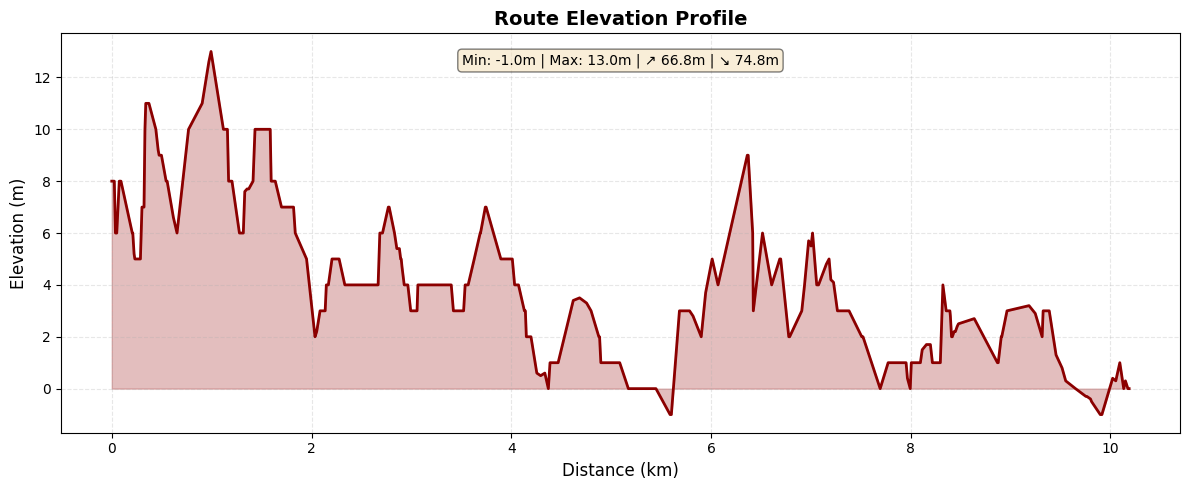

In [6]:
bucket = "cycle_more_bucket"
path = "raw_ors_data/belgium/Amsterdam_route_342962.json"

route_json = load_route_json_from_gcs(bucket, path)
coords, elevations = extract_coords(route_json)
print(f"Extracted {len(coords)} coordinate points with elevation data")
print(f"Elevation range: {min(elevations):.1f}m to {max(elevations):.1f}m")

# Plot the route on the map
m = plot_route_coords(coords)
display(m)

# Plot the elevation profile
fig, ax = plot_elevation_profile(elevations, coords)
plt.show()

In [41]:
coords

[(51.869102, 4.494472),
 (51.868984, 4.494477),
 (51.868912, 4.494491),
 (51.868852, 4.494548),
 (51.868828, 4.494615),
 (51.868816, 4.49472),
 (51.868818, 4.495774),
 (51.868753, 4.49595),
 (51.868699, 4.496097),
 (51.868677, 4.496158),
 (51.868525, 4.496376),
 (51.868464, 4.496426),
 (51.868273, 4.496516),
 (51.867901, 4.496628),
 (51.867037, 4.496763),
 (51.865745, 4.497124),
 (51.865715, 4.497131),
 (51.86444, 4.497506),
 (51.864273, 4.497553),
 (51.863989, 4.497589),
 (51.863724, 4.497578),
 (51.863426, 4.49749),
 (51.863374, 4.497472),
 (51.863357, 4.497468),
 (51.863055, 4.497341),
 (51.862951, 4.497294),
 (51.862651, 4.49715),
 (51.862396, 4.497047),
 (51.862138, 4.496937),
 (51.862147, 4.495224),
 (51.862072, 4.494969),
 (51.861964, 4.494725),
 (51.86184, 4.494569),
 (51.861719, 4.494497),
 (51.861577, 4.494458),
 (51.861312, 4.494462),
 (51.860732, 4.49445),
 (51.859975, 4.49444),
 (51.859419, 4.494428),
 (51.859396, 4.494427),
 (51.858833, 4.494415),
 (51.858798, 4.494415),


In [7]:
elevations

[8.0,
 8.0,
 8.0,
 6.0,
 6.0,
 6.0,
 8.0,
 8.0,
 6.0,
 6.0,
 5.2,
 5.0,
 5.0,
 5.0,
 5.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 10.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 10.0,
 9.2,
 9.0,
 9.0,
 8.0,
 8.0,
 6.6,
 6.0,
 10.0,
 11.0,
 12.6,
 13.0,
 10.0,
 10.0,
 10.0,
 8.0,
 8.0,
 8.0,
 6.0,
 6.0,
 6.0,
 6.0,
 7.6,
 7.7,
 7.7,
 8.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 7.0,
 7.0,
 6.0,
 5.0,
 2.0,
 2.2,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 4.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 6.0,
 6.0,
 6.0,
 7.0,
 7.0,
 6.0,
 5.4,
 5.4,
 5.4,
 5.0,
 5.0,
 4.7,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 4.0,
 4.0,
 4.0,
 5.0,
 6.0,
 6.0,
 7.0,
 7.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 4.0,
 4.0,
 3.0,
 3.0